In [3]:
import cv2
import random
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt
import gc
import gymnasium as gym
import ale_py

# import gym
from gym.wrappers import AtariPreprocessing, FrameStack

gym.register_envs(ale_py)


In [2]:
%matplotlib inline

# RL Libraries

## Stablebaseline 3

In [8]:
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

In [28]:
from stable_baselines3.common.vec_env import DummyVecEnv

def train_stable_baselines(env_fn, total_timesteps):
    
    env = DummyVecEnv([env_fn])
    start_time = time.time()
    model = SB3DQN(
        policy='MlpPolicy',
        env=env,
        learning_rate=0.0002,
        buffer_size=1000,
        learning_starts=1000,
        batch_size=128,
        gamma=0.99,
        train_freq=256,
        gradient_steps=128,
        target_update_interval=10,
        exploration_fraction=0.16,
        exploration_final_eps=0.04,
        policy_kwargs=dict(net_arch=[256,256,128]),
        verbose=1
    )
    
    callback = TrainingMonitorCallback()
    
    model.learn(total_timesteps=total_timesteps, callback=callback)
    training_time = time.time() - start_time

    # Evaluation after training
    eval_rewards = []
    num_eval_episodes = 10
    for _ in range(num_eval_episodes):
        obs = env.reset()
        total_reward = 0
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated = env.step(action)
            total_reward += reward[0]
        eval_rewards.append(total_reward)
    
    avg_reward = np.mean(eval_rewards)

    return training_time, avg_reward, callback

In [25]:
from stable_baselines3 import DQN as SB3DQN
from stable_baselines3.common.callbacks import BaseCallback

class TrainingMonitorCallback(BaseCallback):
    def __init__(self, verbose=1):
        super(TrainingMonitorCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.epsilon_values = []
        self.total_reward = 0

    def _on_step(self) -> bool:
        reward = self.locals["rewards"][0]
        self.total_reward += reward

        done = self.locals["dones"][0]
        if done:
            self.episode_rewards.append(self.total_reward)
            self.epsilon_values.append(self.model.exploration_rate)
            self.total_reward = 0 
        
        return True 

    def plot_results(self):
        
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.episode_rewards, label="Total Reward per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Total Rewards Per Episode")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.epsilon_values, label="Epsilon Decay", color='r')
        plt.xlabel("Episode")
        plt.ylabel("Epsilon")
        plt.title("Epsilon Decay Over Time")
        plt.legend()

        plt.tight_layout()
        plt.show()

## Cartpole using Stable-baselines3 DQN

Using cuda device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2499     |
|    time_elapsed     | 0        |
|    total_timesteps  | 79       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2826     |
|    time_elapsed     | 0        |
|    total_timesteps  | 133      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 3535     |
|    time_elapsed     | 0        |
|    total_timesteps  | 236      |
----------------------------------
----------------------------------
| 

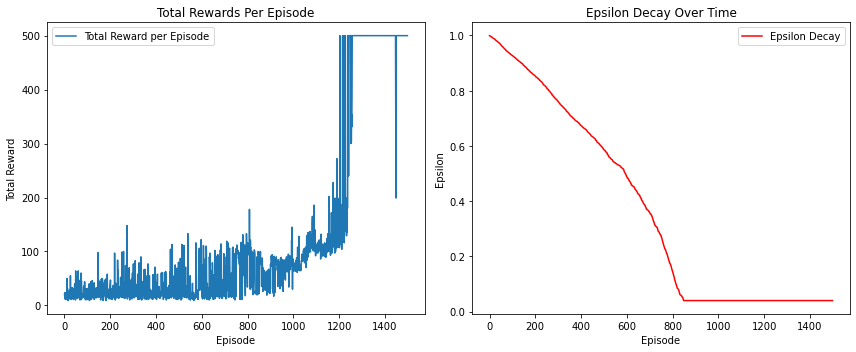

Training Time: 442.21 seconds
Average Reward from Evaluation: 500.00


In [36]:
def make_cartpole_env():
    return gym.make("CartPole-v1", render_mode="ansi")

total_timesteps = 200000
training_time, avg_reward, callback = train_stable_baselines(make_cartpole_env, total_timesteps)

callback.plot_results()

print(f"Training Time: {training_time:.2f} seconds")
print(f"Average Reward from Evaluation: {avg_reward:.2f}")

## Drone Env using Stable-baselines3 DQN

In [15]:
class Env_3_Drone_Delivery(gym.Env):
    def __init__(self, grid_size=6, stochastic=False, multiple_deliveries=False):
        super(Env_3_Drone_Delivery, self).__init__()

        self.grid_size = grid_size
        self.stochastic = stochastic
        self.multiple_deliveries = multiple_deliveries
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'PICKUP', 'DROPOFF']
        self.no_fly_zones = {(1, 1), (2, 3), (4, 4)}  # no-fly zones

        self.action_space = spaces.Discrete(len(self.actions))
#         self.observation_space = spaces.Tuple((
#             spaces.Discrete(self.grid_size),  # x position
#             spaces.Discrete(self.grid_size),  # y position
#             spaces.Discrete(2)                # has_package (0 or 1)
#         ))
        self.observation_space = spaces.Box(
                    low=np.array([0, 0, 0]),  # x, y, package_picked (0 or 1)
                    high=np.array([self.grid_size - 1, self.grid_size - 1, 1]),  
                    dtype=np.float32
                )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.drone_position = (0, 0)  # Starting point - top-left corner of the Warehouse
        self.package_picked = False
        self.delivery_target = (self.grid_size - 1, self.grid_size - 1)  # Customer location (bottom-right corner)
        self.pickup_location = (0, 0)  # Pickup location of the Warehouse
        self.steps_taken = 0
        self.total_reward = 0
        if self.multiple_deliveries:
            self.delivery_count = 0

        return self.drone_position + (self.package_picked,), {}

    def step(self, action):
        reward = -1
        new_position = list(self.drone_position[:2])

        if action == 0 and self.drone_position[0] > 0:  # UP
            new_position[0] -= 1
        elif action == 1 and self.drone_position[0] < self.grid_size - 1:  # DOWN
            new_position[0] += 1
        elif action == 2 and self.drone_position[1] > 0:  # LEFT
            new_position[1] -= 1
        elif action == 3 and self.drone_position[1] < self.grid_size - 1:  # RIGHT
            new_position[1] += 1

        if self.stochastic and random.random() < 0.1:  # 10% chance of deviation
            new_position = self._applying_stochastic_conditions(new_position)

        new_position = tuple(new_position)
        if new_position in self.no_fly_zones:
            reward = -20
        else:
            self.drone_position = new_position

        if action == 4 and self.drone_position == self.pickup_location and not self.package_picked:
            self.package_picked = True
            reward += 10 

        terminated = False
        if action == 5 and self.drone_position == self.delivery_target and self.package_picked:
            reward = 20
            self.package_picked = False
            if self.multiple_deliveries:
                self.delivery_count += 1
            else:
                terminated = True

        self.steps_taken += 1
        self.total_reward += reward
        truncated = self.steps_taken >= 100 

        return self.drone_position + (self.package_picked,), reward, terminated, truncated, {}

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size, 3))  # RGB grid
        fig, ax = plt.subplots()
        drone_empty = mpimg.imread("drone_empty.jpg")
        drone_loaded = mpimg.imread("drone_loaded.jpg")
        warehouse = mpimg.imread("warehouse.jpg")
        customer = mpimg.imread("customer.jpg")
        no_fly_zone = mpimg.imread("no_fly_zone.jpg")
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if (i, j) in self.no_fly_zones:
                    ax.imshow(no_fly_zone, extent=[j, j + 1, self.grid_size - i - 1, self.grid_size - i])
                if (i, j) == self.pickup_location:
                    ax.imshow(warehouse, extent=[j, j + 1, self.grid_size - i - 1, self.grid_size - i])
                if (i, j) == self.delivery_target:
                    ax.imshow(customer, extent=[j, j + 1, self.grid_size - i - 1, self.grid_size - i])

        if self.package_picked:
            ax.imshow(drone_loaded, extent=[self.drone_position[1], self.drone_position[1] + 1,
                                            self.grid_size - self.drone_position[0] - 1,
                                            self.grid_size - self.drone_position[0]])
        else:
            ax.imshow(drone_empty, extent=[self.drone_position[1], self.drone_position[1] + 1,
                                        self.grid_size - self.drone_position[0] - 1,
                                        self.grid_size - self.drone_position[0]])

        ax.set_xticks(range(self.grid_size + 1))
        ax.set_yticks(range(self.grid_size + 1))
        ax.grid(True, which='both', color='black', linestyle='-', linewidth=1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.show()

    def _applying_stochastic_conditions(self, position):
        deviations = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        deviation = random.choice(deviations)
        new_position = (position[0] + deviation[0], position[1] + deviation[1])
        return tuple(max(0, min(self.grid_size - 1, x)) for x in new_position)


In [17]:
from stable_baselines3.common.evaluation import evaluate_policy
from gym.envs.registration import register
from gymnasium import spaces

env = Env_3_Drone_Delivery(grid_size=6, stochastic=False, multiple_deliveries=False)

model = DQN(
    policy="MlpPolicy",
    env=env,
    learning_rate=1e-3,
    buffer_size=10_000,
    batch_size=64,  
    learning_starts=1000,
    gamma=0.99, 
    train_freq=4,
    target_update_interval=1000,
    exploration_fraction=0.1,  
    exploration_final_eps=0.05,
    verbose=1,
    device="auto"
)

model.learn(total_timesteps=100_000)

model.save("dqn_drone_delivery")

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, render=False)

print(f" Training Completed!")
print(f" Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -226     |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 8792     |
|    time_elapsed     | 0        |
|    total_timesteps  | 400      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -240     |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 10567    |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.8     |
|    ep_rew_mean      | -214  

## Frozen Lake using Stable-baselines3 DQN

Using cuda device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6277     |
|    time_elapsed     | 0        |
|    total_timesteps  | 28       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6224     |
|    time_elapsed     | 0        |
|    total_timesteps  | 65       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.987    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6301     |
|    time_elapsed     | 0        |
|    total_timesteps  | 111      |
----------------------------------
----------------------------------
| 

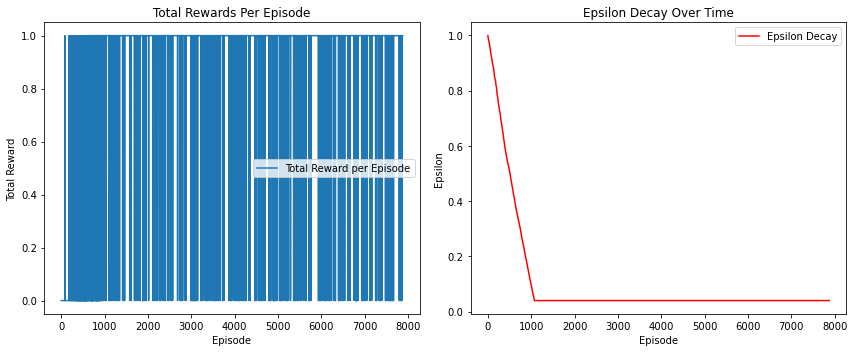

Training Time: 114.52 seconds
Average Reward from Evaluation: 1.00


In [34]:
def make_frozenlake_env():
    return gym.make("FrozenLake-v1", is_slippery=False, render_mode="ansi")


total_timesteps = 50000
training_time, avg_reward, callback = train_stable_baselines(make_frozenlake_env, total_timesteps)

callback.plot_results()

print(f"Training Time: {training_time:.2f} seconds")
print(f"Average Reward from Evaluation: {avg_reward:.2f}")